In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
project_folder = r'/content/drive/MyDrive/Colab Notebooks/DeepLearning'
sys.path.insert(0, project_folder)

In [ ]:
import torch
import torch.nn as nn

#from MusicNet import MusicNet
import utils
from MusicNetManyhotNotes import MusicNet
from torchaudio import transforms
from torchvision import models
from os.path import join as path_join
from datetime import datetime
from torch.optim.lr_scheduler import StepLR 
# from dedicated_layers_model import get_model, train_single_layer
import dedicated_layers_model
from matplotlib import pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
train_loader, val_loader, test_loader = utils.get_dataset_loaders()

loading cached metadata
loading cached metadata
loading cached metadata


In [ ]:
import importlib
importlib.reload(utils)
importlib.reload(dedicated_layers_model)

<module 'dedicated_layers_model' from '/content/drive/MyDrive/Colab Notebooks/DeepLearning/dedicated_layers_model.py'>

In [ ]:
# In validation we don't care about sampling stuff at random
val_loader.dataset.all_metadata = val_loader.dataset.all_metadata.sort_values('csv_id')
test_loader.dataset.all_metadata = test_loader.dataset.all_metadata.sort_values('csv_id')

In [ ]:
mse_model = torch.load('/content/drive/MyDrive/Colab Notebooks/DeepLearning/trained_models/mse_loss_instrument')
iou_model = torch.load('/content/drive/MyDrive/Colab Notebooks/DeepLearning/trained_models/iou_loss_instrument')

In [ ]:
import copy 
# only using the first half of the validataion set for it
val1 = copy.deepcopy(val_loader)
val2 = copy.deepcopy(val_loader)

n_val_items = len(val_loader.dataset.all_metadata)
val1.dataset.all_metadata = val_loader.dataset.all_metadata[:n_val_items//2]
val2.dataset.all_metadata = val_loader.dataset.all_metadata[n_val_items//2:]

In [ ]:
# capturing the interesting means 
dataset_means = torch.zeros((1,11))
noise_input_means = torch.zeros((1,11))
val_prediction_means = torch.zeros((1,11))

with torch.no_grad():
    for batch_id, (batch_data, instrument, note) in enumerate(val1):
        dataset_means += instrument.sum(axis=0)

        batch_multi_channel = batch_data.repeat(1,3,1,1).to(device)
        val_output = iou_model(batch_multi_channel).cpu()
        val_prediction_means += val_output.sum(axis=0)

        random_input = torch.bernoulli(0.2*torch.ones(batch_data.shape)).repeat(1,3,1,1).to(device)
        random_output = iou_model(random_input).cpu()
        noise_input_means += random_output.sum(axis=0)

        if batch_id % 500 == 0:
            print(batch_id)


dataset_means /= len(val1.dataset.all_metadata)
val_prediction_means /= len(val1.dataset.all_metadata)
noise_input_means /= len(val1.dataset.all_metadata)

0
500


In [ ]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'probability')

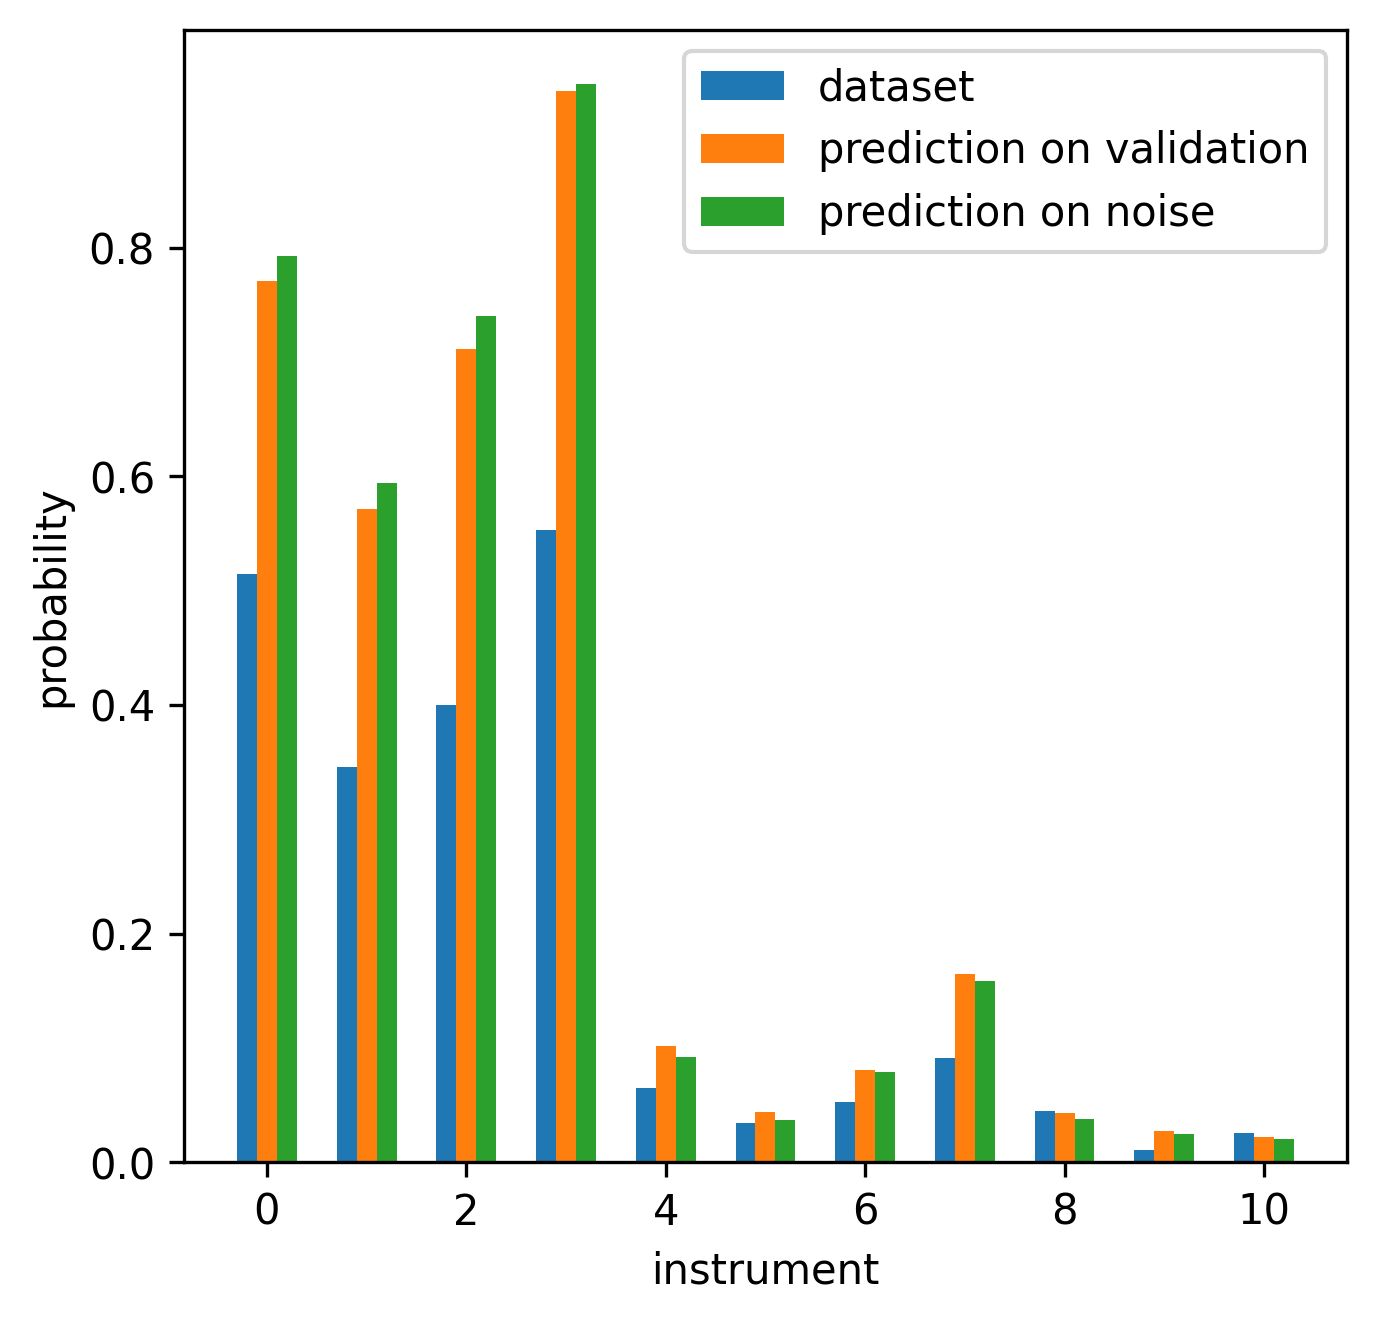

In [ ]:
import numpy as np
plt.figure(figsize=(5,5), dpi = 300)
plt.bar(np.arange(11)-0.2,dataset_means.reshape(-1), width=0.2, label='dataset')
plt.bar(np.arange(11),val_prediction_means.reshape(-1), width=0.2, label='prediction on validation')
plt.bar(np.arange(11)+0.2,noise_input_means.reshape(-1), width=0.2, label='prediction on noise')
plt.legend()
plt.xlabel('instrument')
plt.ylabel('probability')

In [ ]:
dataset_normed_results = []
noise_normed_results = []
val_normed_results = []

thresholds = [0, 0.05, 0.1, 0.2, 0.3]
for threshold in thresholds:
    print(f'threshold {threshold}')
    dataset_normed_results.append(utils.get_test_score(
        test_loader=val2, 
        model=iou_model, 
        target='instrument', 
        predictor=utils.uniform_threshold_norm_predictor, 
        predictor_params=(dataset_means, threshold),
        device=device))
    print(f'dataset_means = {dataset_normed_results[-1]}') 

    print(f'threshold {threshold}')
    noise_normed_results.append(utils.get_test_score(
        test_loader=val2, 
        model=iou_model, 
        target='instrument', 
        predictor=utils.uniform_threshold_norm_predictor, 
        predictor_params=(noise_input_means, threshold),
        device=device))
    print(f'noise_normed_results = {noise_normed_results[-1]}') 

    print(f'threshold {threshold}')
    val_normed_results.append(utils.get_test_score(
        test_loader=val2, 
        model=iou_model, 
        target='instrument', 
        predictor=utils.uniform_threshold_norm_predictor, 
        predictor_params=(val_prediction_means, threshold),
        device=device))
    print(f'val_normed_results = {val_normed_results[-1]}') 

threshold 0
dataset_means = (0.0, 0.9945239817634293, 81.0865598027127)
threshold 0
noise_normed_results = (0.0, 0.6618916236267895, 54.75856966707768)
threshold 0
val_normed_results = (0.0, 0.7358641341834761, 44.867324290998766)
threshold 0.05
dataset_means = (0.0, 0.9831429484699113, 55.91454993834772)
threshold 0.05
noise_normed_results = (0.0, 0.5936979525916455, 24.52478421701603)
threshold 0.05
val_normed_results = (0.0, 0.6415100688077253, 17.471763255240443)
threshold 0.1
dataset_means = (0.0, 0.9702982789656971, 37.42614056720099)
threshold 0.1
noise_normed_results = (0.0, 0.5572921047761646, 7.326263871763255)
threshold 0.1
val_normed_results = (0.0, 0.5840244948772733, 6.326387176325524)
threshold 0.2
dataset_means = (0.0, 0.7962096869164381, 17.666707768187422)
threshold 0.2
noise_normed_results = (0.0011097410604192356, 0.5346646254268939, 2.605548705302096)
threshold 0.2
val_normed_results = (0.0009864364981504315, 0.5398546457832136, 2.7204685573366216)
threshold 0.3
da

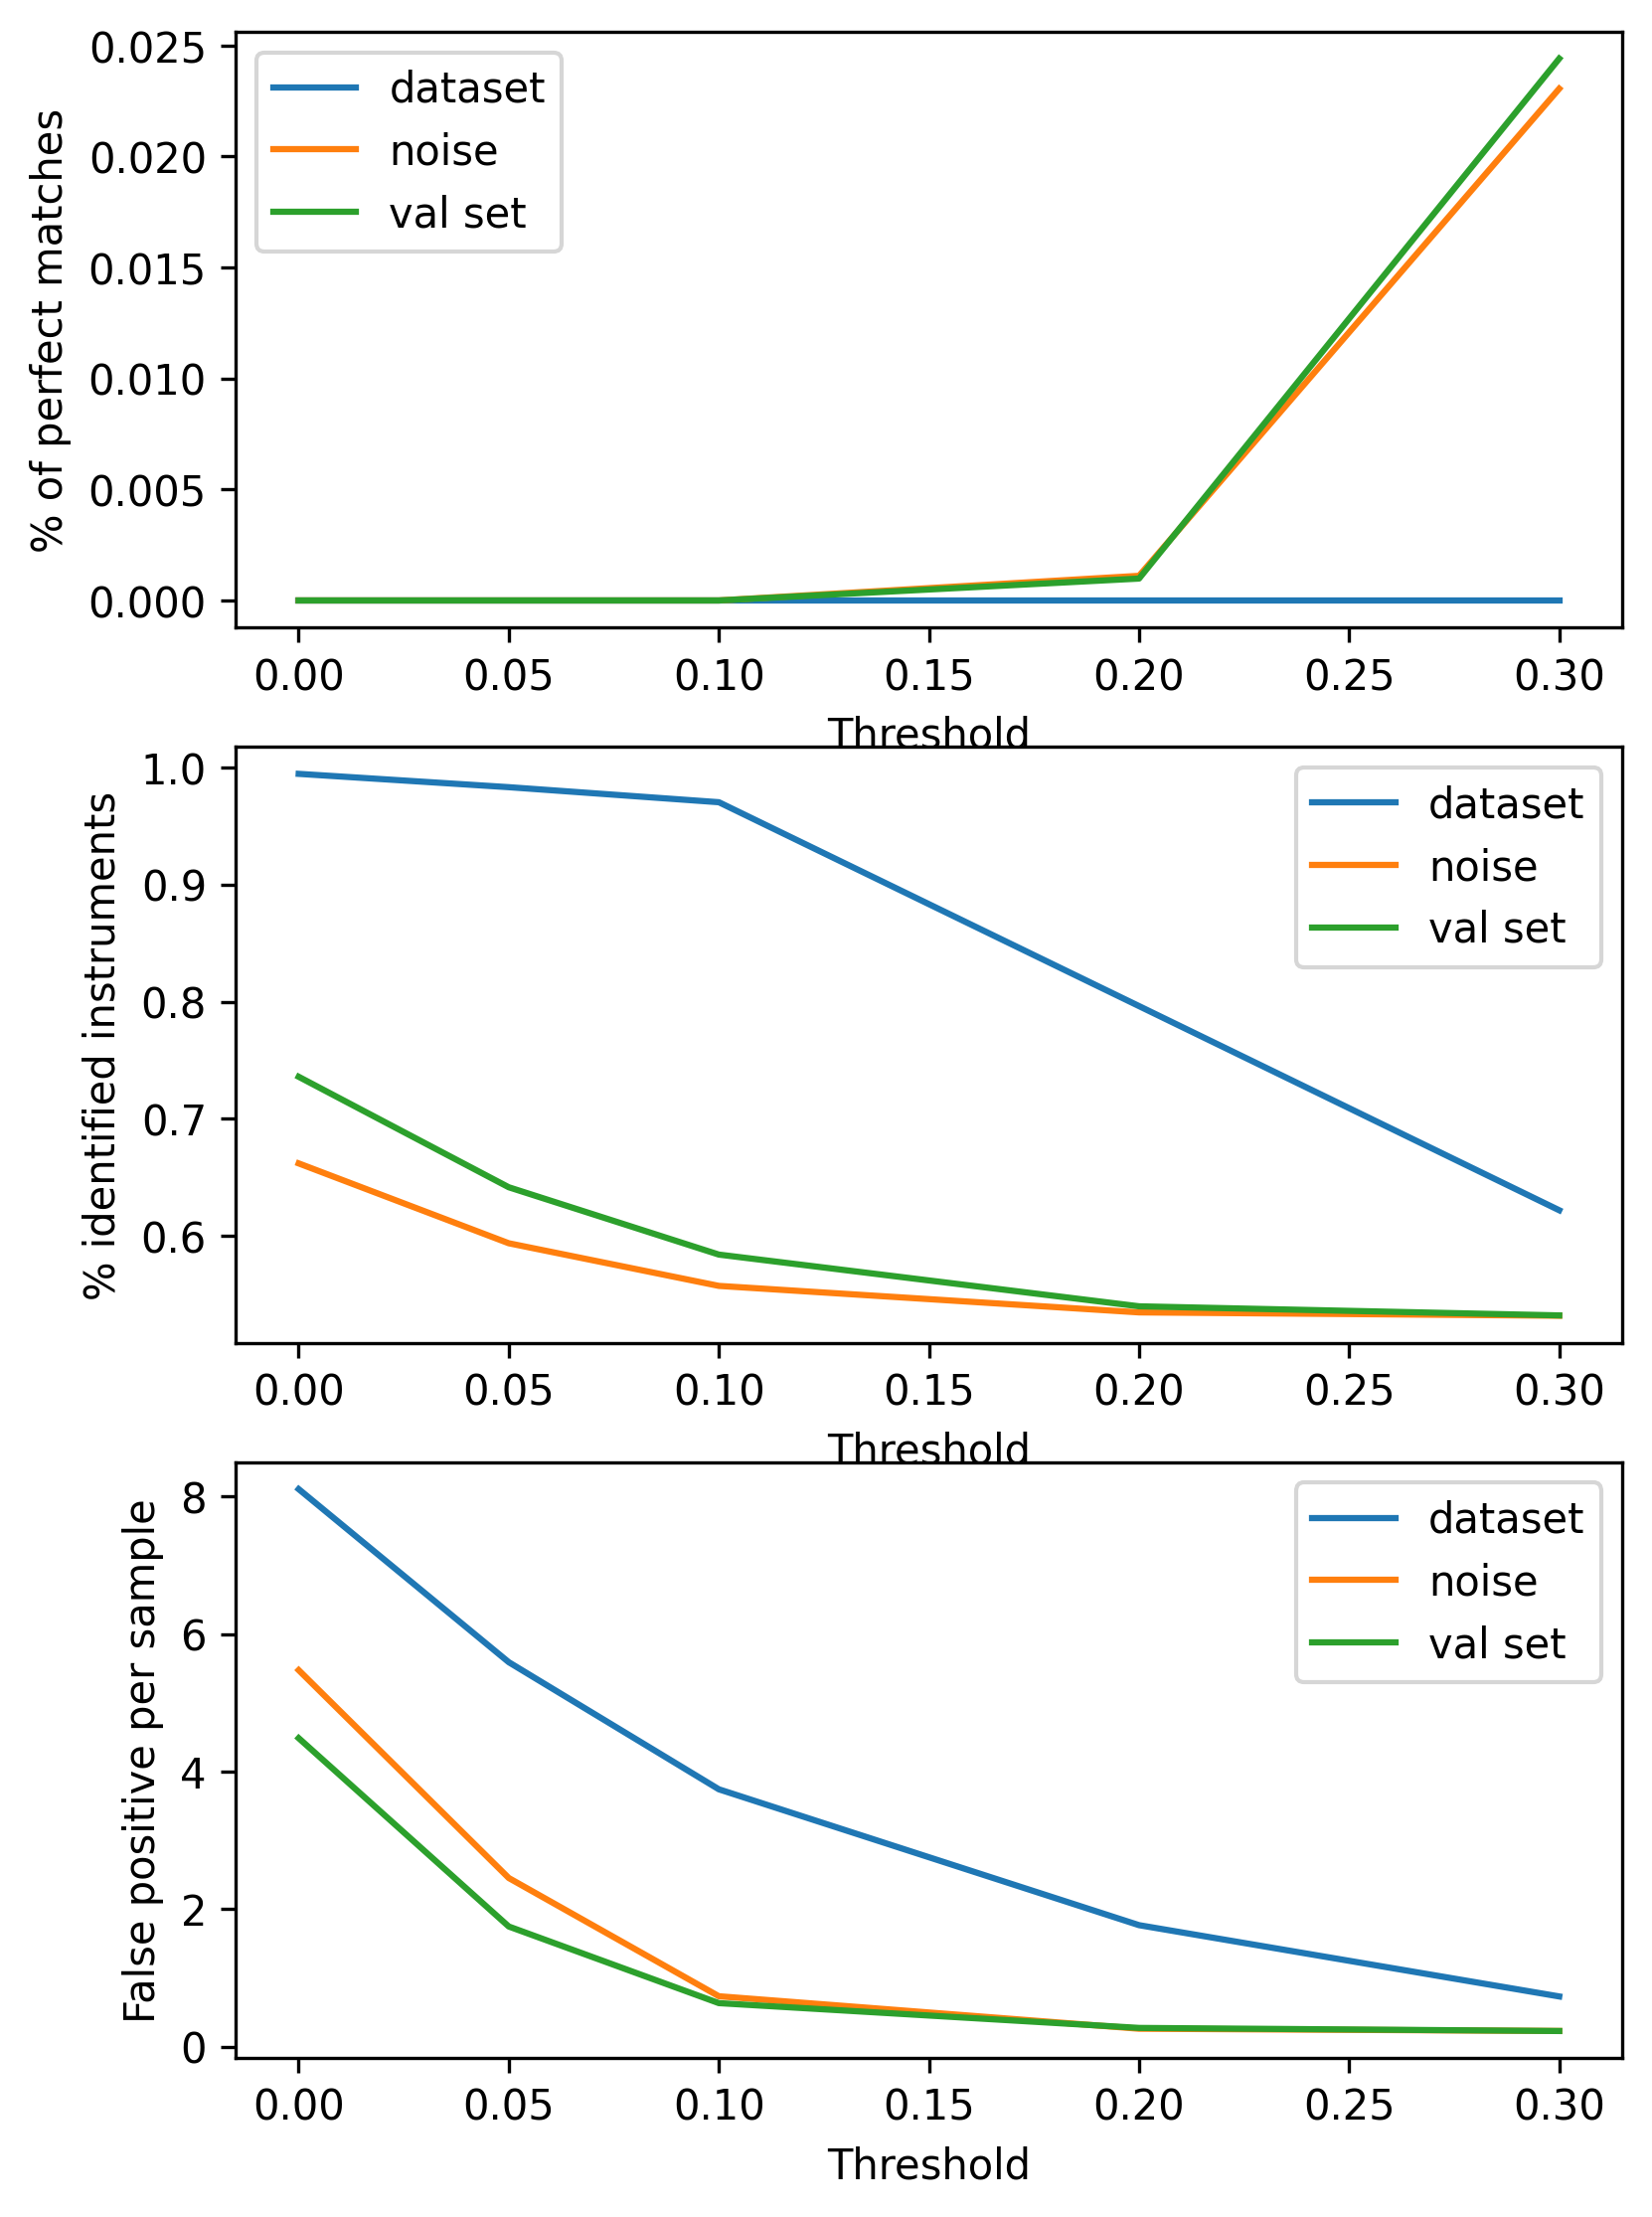

In [ ]:

#dataset_normed_results = []
#noise_normed_results = []
#val_normed_results = []

plt.figure(figsize=(6,9), dpi=300)

plt.subplot(3,1,1)
plt.plot(thresholds, [i[0] for i in dataset_normed_results], label='dataset')
plt.plot(thresholds, [i[0] for i in noise_normed_results], label='noise')
plt.plot(thresholds, [i[0] for i in val_normed_results], label='val set')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('% of perfect matches')

plt.subplot(3,1,2)
plt.plot(thresholds, [i[1] for i in dataset_normed_results], label='dataset')
plt.plot(thresholds, [i[1] for i in noise_normed_results], label='noise')
plt.plot(thresholds, [i[1] for i in val_normed_results], label='val set')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('% identified instruments')

plt.subplot(3,1,3)
plt.plot(thresholds, [i[2]/10 for i in dataset_normed_results], label='dataset')
plt.plot(thresholds, [i[2]/10 for i in noise_normed_results], label='noise')
plt.plot(thresholds, [i[2]/10 for i in val_normed_results], label='val set')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('False positive per sample')

plt.show()


In [ ]:
import numpy as np
dataset_normed_top_n_results = []
noise_normed_top_n_results = []
val_normed_top_n_results = []
no_normed_top_n_results = []

ns = [1, 2, 3, 4]
for n in ns:
    print(f'n {n}')
    no_normed_top_n_results.append(utils.get_test_score(
        test_loader=val2, 
        model=iou_model, 
        target='instrument', 
        predictor=utils.top_n_norm_predictor, 
        predictor_params=(np.zeros(11), n),
        device=device))
    print(f'no_normed_top_n_results = {no_normed_top_n_results[-1]}') 

    dataset_normed_top_n_results.append(utils.get_test_score(
        test_loader=val2, 
        model=iou_model, 
        target='instrument', 
        predictor=utils.top_n_norm_predictor, 
        predictor_params=(dataset_means, n),
        device=device))
    print(f'dataset_normed_top_n_results = {dataset_normed_top_n_results[-1]}') 

    noise_normed_top_n_results.append(utils.get_test_score(
        test_loader=val2, 
        model=iou_model, 
        target='instrument', 
        predictor=utils.top_n_norm_predictor, 
        predictor_params=(noise_input_means, n),
        device=device))
    print(f'noise_normed_top_n_results = {noise_normed_top_n_results[-1]}') 

    val_normed_top_n_results.append(utils.get_test_score(
        test_loader=val2, 
        model=iou_model, 
        target='instrument', 
        predictor=utils.top_n_norm_predictor, 
        predictor_params=(val_prediction_means, n),
        device=device))
    print(f'val_normed_top_n_results = {val_normed_top_n_results[-1]}') 

n 1
no_normed_top_n_results = (0.037361282367447596, 0.5315018253394121, 2.2197287299630086)
dataset_normed_top_n_results = (0.0, 0.46833835231574167, 3.1456226880394573)
noise_normed_top_n_results = (0.0, 0.0427650947998856, 9.383970406905055)
val_normed_top_n_results = (0.0, 0.09239413872579533, 8.656473489519112)
n 2
no_normed_top_n_results = (0.0, 0.7227166433942901, 9.427620221948212)
dataset_normed_top_n_results = (0.0, 0.6629010279100285, 10.304438964241678)
noise_normed_top_n_results = (0.0, 0.09910667720933362, 18.56892725030826)
val_normed_top_n_results = (0.0, 0.2006863949126024, 17.079901356350184)
n 3
no_normed_top_n_results = (0.0, 0.8585740482158779, 17.446979038224413)
dataset_normed_top_n_results = (0.0, 0.8182651705052069, 18.037854500616522)
noise_normed_top_n_results = (0.0, 0.15946905334701636, 27.69494451294698)
val_normed_top_n_results = (0.0, 0.3159014821419559, 25.40184956843403)
n 4
no_normed_top_n_results = (0.0, 0.9632829191971871, 25.922934648581997)
datase

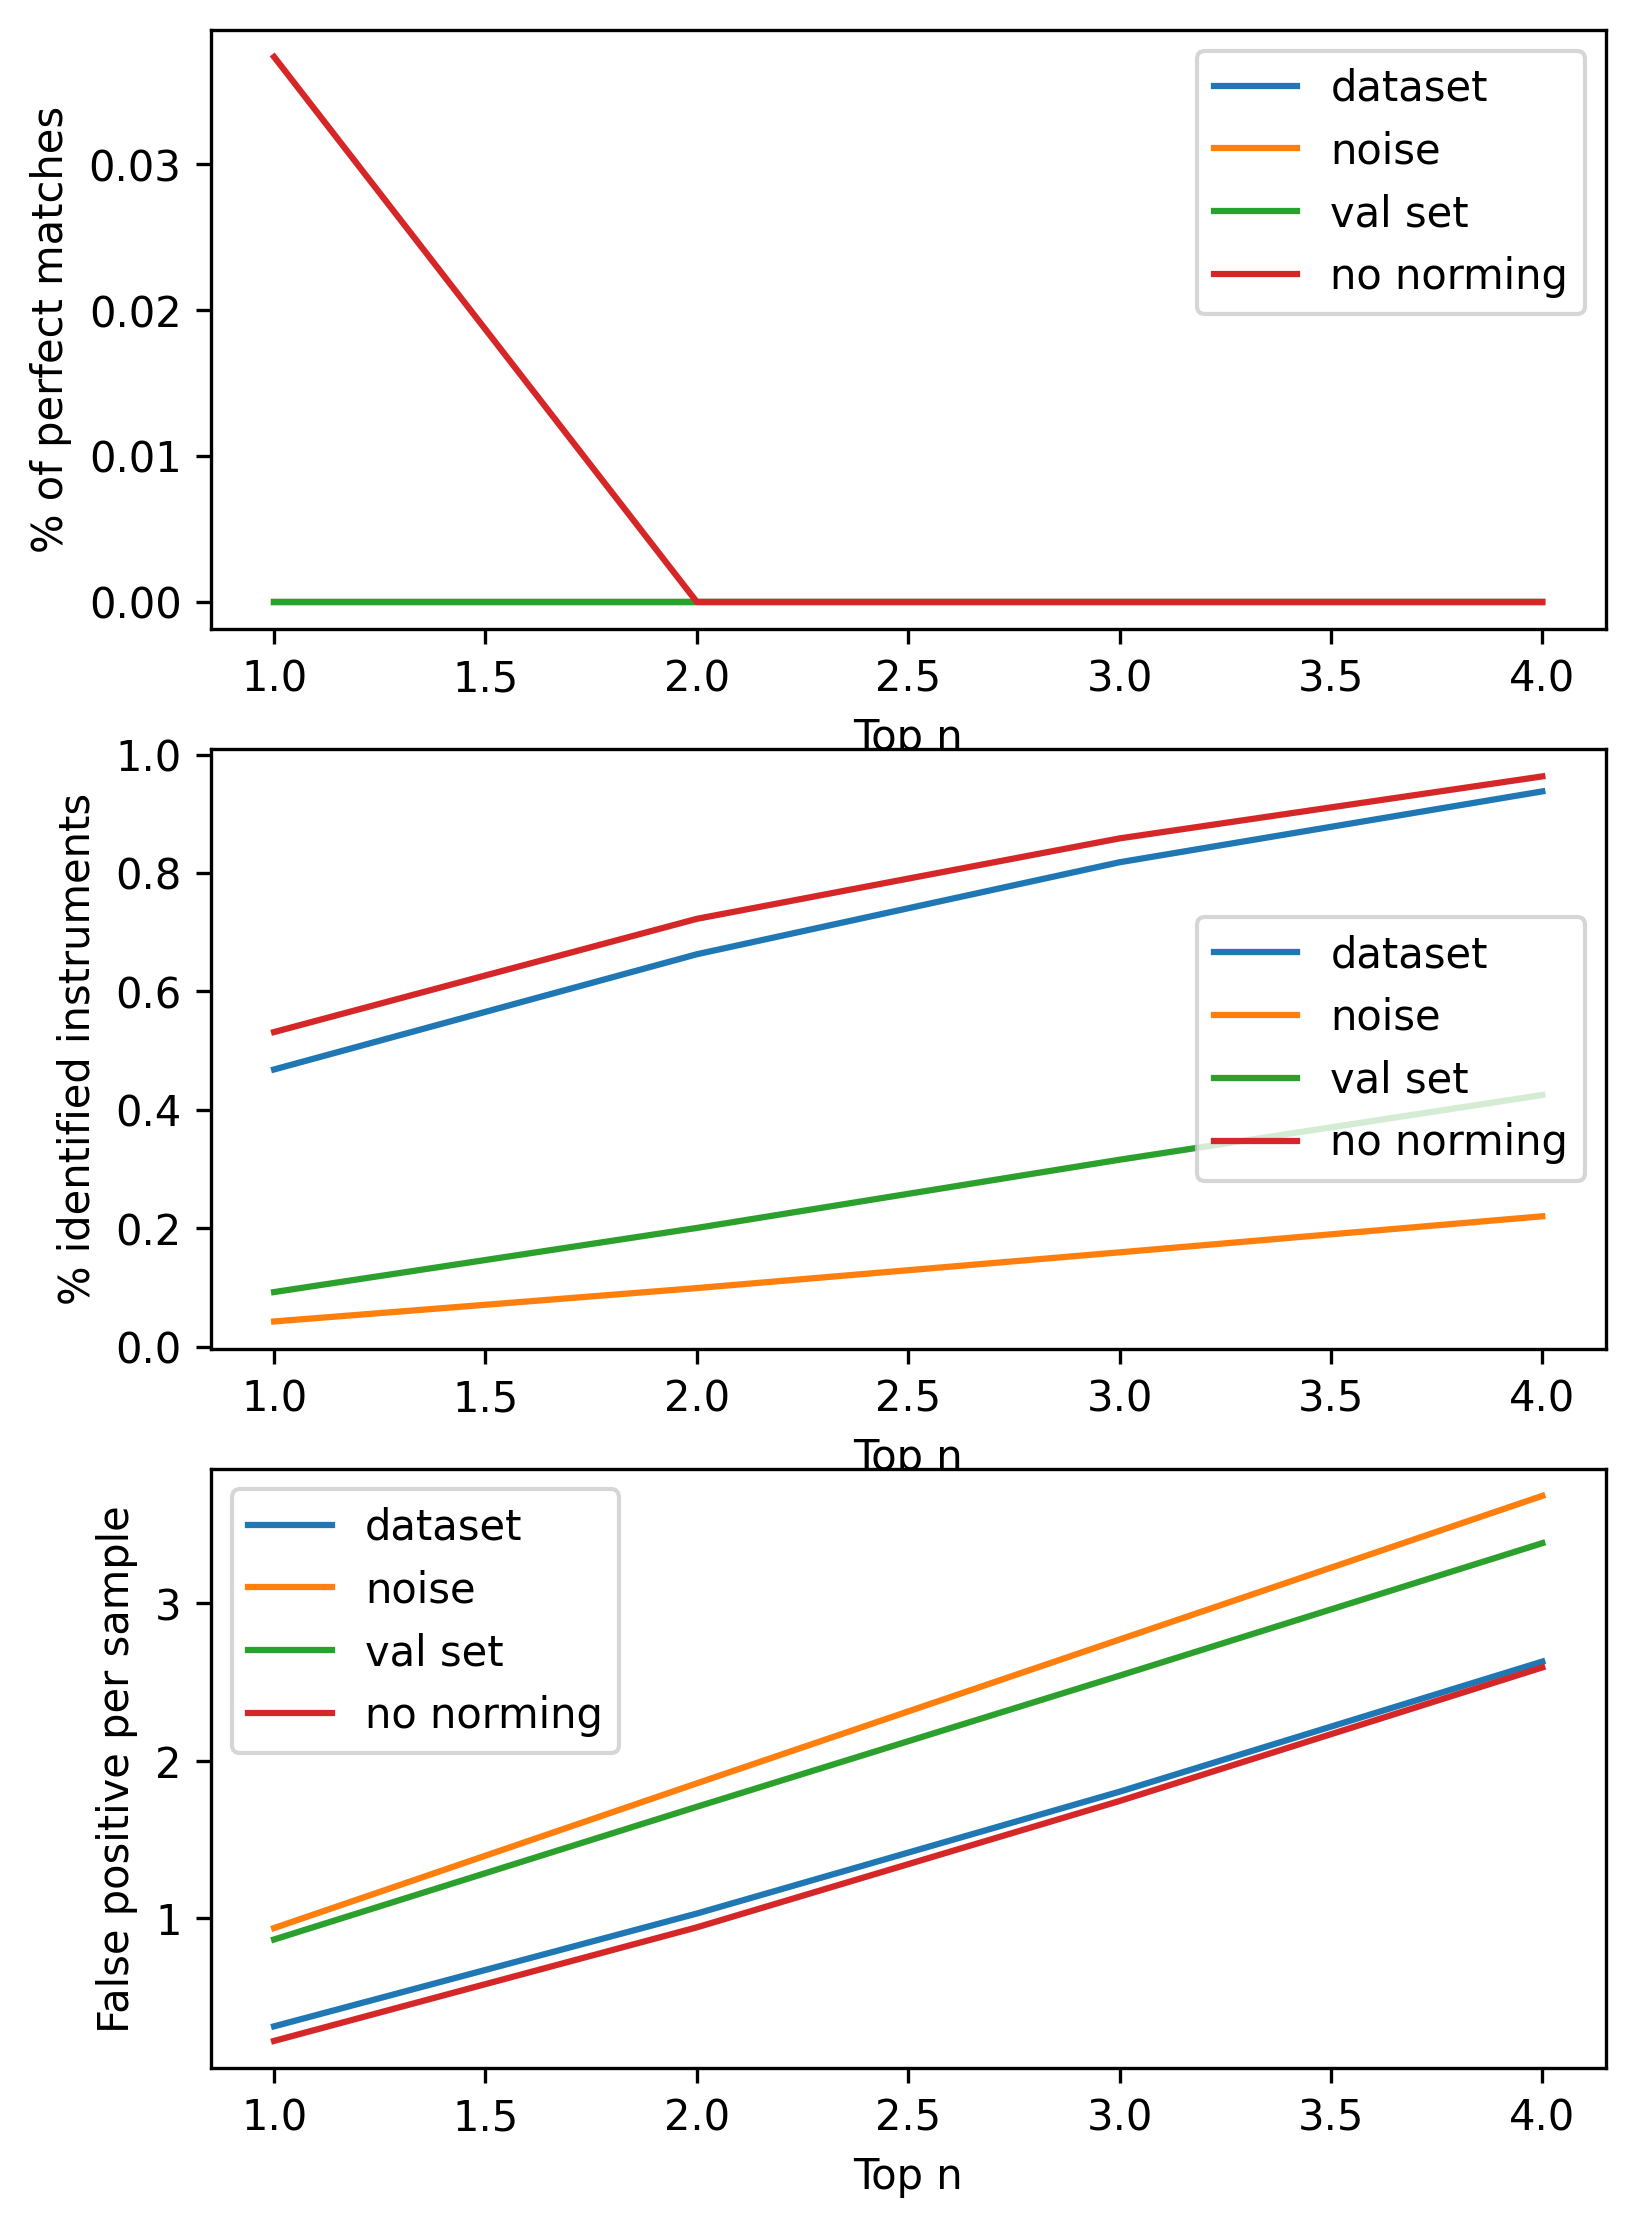

In [ ]:
plt.figure(figsize=(6,9), dpi=300)

plt.subplot(3,1,1)
plt.plot(ns, [i[0] for i in dataset_normed_top_n_results], label='dataset')
plt.plot(ns, [i[0] for i in noise_normed_top_n_results], label='noise')
plt.plot(ns, [i[0] for i in val_normed_top_n_results], label='val set')
plt.plot(ns, [i[0] for i in no_normed_top_n_results], label='no norming')
plt.legend()
plt.xlabel('Top n')
plt.ylabel('% of perfect matches')

plt.subplot(3,1,2)
plt.plot(ns, [i[1] for i in dataset_normed_top_n_results], label='dataset')
plt.plot(ns, [i[1] for i in noise_normed_top_n_results], label='noise')
plt.plot(ns, [i[1] for i in val_normed_top_n_results], label='val set')
plt.plot(ns, [i[1] for i in no_normed_top_n_results], label='no norming')
plt.legend()
plt.xlabel('Top n')
plt.ylabel('% identified instruments')

plt.subplot(3,1,3)
plt.plot(ns, [i[2]/10 for i in dataset_normed_top_n_results], label='dataset')
plt.plot(ns, [i[2]/10 for i in noise_normed_top_n_results], label='noise')
plt.plot(ns, [i[2]/10 for i in val_normed_top_n_results], label='val set')
plt.plot(ns, [i[2]/10 for i in no_normed_top_n_results], label='no norming')
plt.legend()
plt.xlabel('Top n')
plt.ylabel('False positive per sample')

plt.show()


In [ ]:
import numpy as np
utils.get_test_score(
    test_loader=test_loader, 
    model=iou_model, 
    target='instrument', 
    predictor=utils.top_n_norm_predictor, 
    predictor_params=(np.zeros(11), 3),
    device=device)

(0.0, 0.7620539233720502, 16.613308687615525)